In [16]:
#@title Initialize environment

#@markdown If you like, you can link this instance to a google drive. This is a 
#@markdown convenient way to pass files in and out of this analysis. It will 
#@markdown also allow you to save your work. If you put `biophysics` into the form
#@markdown field below, the analyis will save all of its calculations in the 
#@markdown `biophysics` directory in MyDrive (i.e. the top directory at
#@markdown https://drive.google.com). This script will create the directory if 
#@markdown it does not already exist. If the directory already exists, any files
#@markdown that are already in that directory will be available for the analysis. 
#@markdown You could, for example, put a file called `data.csv` in `biophysics` and then
#@markdown access it as "data.csv" in all cells below.
#@markdown <br/>
#@markdown Note: Google may prompt you for permission to access the drive. 
#@markdown To work in a temporary colab environment, leave this blank. Your results
#@markdown will disappear when you close the directory. 

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

# ------------------------------------------------------------------------------
# Imports

if RUNNING_IN_COLAB:
    %pip install -q ipywidgets
    !git clone --branch master https://github.com/harmsm/kinetics_simulator
    %pip install kinetics_simulator/
    
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy

import kinetics_simulator as ks

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import os

# ------------------------------------------------------------------------------
# Environment

if RUNNING_IN_COLAB:
    
    working_dir = "/content/"

    # Select a working directory on google drive
    google_drive_directory = "" #@param {type:"string"}
    google_drive_directory = google_drive_directory.strip()

    # Set up google drive
    if google_drive_directory != "":

        from google.colab import drive
        drive.mount('/content/gdrive/')

        working_dir = f"/content/gdrive/MyDrive/{google_drive_directory}"
        os.system(f"mkdir -p {working_dir}")

    os.chdir(working_dir)
    print(f"Working directory: {os.getcwd()}/")

    print("\nCurrent directory contents:")
    print(os.getcwd())
    for f in os.listdir("."):
        print(f"    {f}")
    print()

# ------------------------------------------------------------------------------
# Default graph label sizing

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ------------------------------------------------------------------------------
# Functions

def plot_actin(history,
               invisible_species=("A1","A2","A3","A4","ARP"),
               time_scalar=3000,
               label=None,
               fig=None,
               ax=None):
    """
    Function for plotting actin polymerization experiments.  
    
    Fluorescence output is proportional to actin polymer length. 
    """

    if fig is None:
        fig, ax = plt.subplots(1,figsize=(6,6))
        ax.set_xlabel("time (s)")
        ax.set_ylabel("actin molecules in polymer")
    
    signal = []
    for c in history.columns:
        if c[0] != "A":
            signal.append(0)
        else:
            if c in invisible_species:
                signal.append(0)
            else:
                signal.append(float(c[1:].split("_")[0]))

    signal_vector = np.array(signal)
    
    final_signal = np.sum(signal_vector*history.iloc[:,:],1)
    ax.plot(history.time*time_scalar,final_signal,lw=2,label=label)
    
    return fig, ax

            
def print_rxn(rxn,num_lines=12):
    
    if num_lines % 2 != 0:
        num_lines += 1
    idx = num_lines // 2
    
    print("Running simulation for the following reaction scheme:")
    
    rxn = rxn.strip()
    
    lines = rxn.split("\n")
    if len(lines) > num_lines:
        head = "\n".join(lines[:idx])
        tail = "\n".join(lines[-idx:])
        
        out = f"{head}\n...\n{tail}"
    else:
        out = rxn
        
    print()
    print(out)
    print()


## Running kinetics simulations

### <font color='#9D33FF' size="+2">Interpret</font>

<font size="+1">Which of the reaction schemes (1,2 or 3) is represented by the field below?</font>

1. $A \rightarrow B \rightarrow C$
2. $A \rightarrow C \rightarrow B$
2. $A \rightleftarrows B \rightleftarrows C$

In [18]:
# Define a reaction:

rxn = \
"""
# Initial concentrations
A = 1000
B = 60
C = 20

# Reactions; rate constants
A -> B; 1
B -> C; 5
C -> A; 0.1
"""

### Run the reaction using a Markov matrix. 

Running simulation for the following reaction scheme:

# Initial concentrations
A = 1000
B = 60
C = 20

# Reactions; rate constants
A -> B; 1
B -> C; 5
C -> A; 0.1



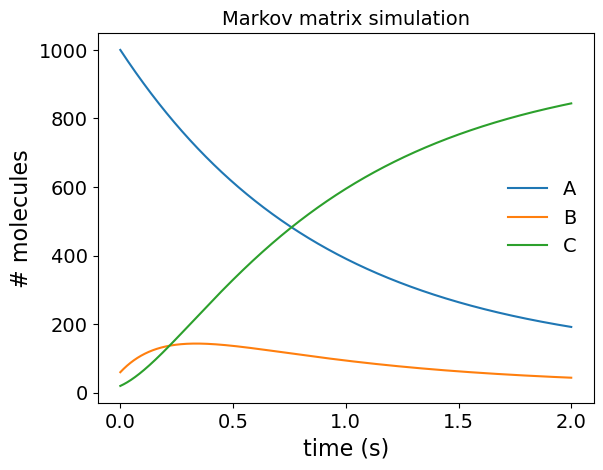

In [24]:
#@title Press the "Play" button on the left to run.

rxn = \
"""
# Initial concentrations
A = 1000
B = 60
C = 20

# Reactions; rate constants
A -> B; 1
B -> C; 5
C -> A; 0.1
"""

# create markov model, choosing dt such that p_self is 0.999
m = ks.MarkovModel(rxn,min_self_prob=0.999)

print_rxn(rxn)

# run 10,000 time steps
for i in range(10000):
    m.take_step()

# Plot result
plt.plot(m.conc_history.time,m.conc_history.A,label="A")
plt.plot(m.conc_history.time,m.conc_history.B,label="B")
plt.plot(m.conc_history.time,m.conc_history.C,label="C")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("# molecules")
plt.title("Markov matrix simulation")
None

### <font color='#9D33FF' size="+2">Interpret</font>

<font size="+1">What does each curve represent? What is the molecular origin of the "S-shape" of the C curve?</font>

### Run reaction as a Gillespie simulation

Running simulation for the following reaction scheme:

# Initial concentrations
A = 1000
B = 60
C = 20

# Reactions; rate constants
A -> B; 1
B -> C; 5
C -> A; 0.1



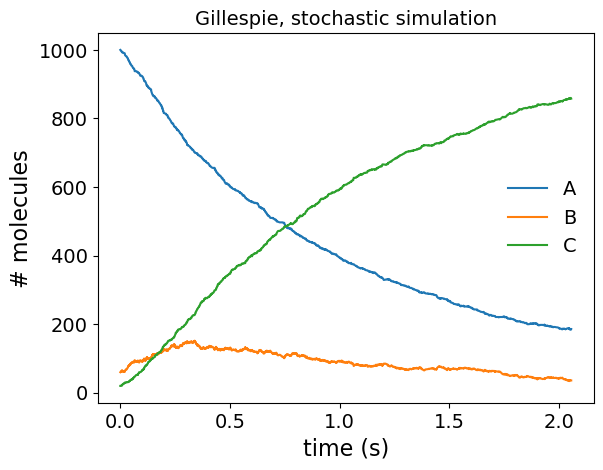

In [25]:
#@title Press the "Play" button on the left to run.

# create markov model
g = ks.Gillespie(rxn)

print_rxn(rxn)

# Run 2,000 time steps (will correspond to ~2 seconds)
for i in range(2000):
    g.take_step()
    
# Plot result
plt.plot(g.conc_history.time,g.conc_history.A,label="A")
plt.plot(g.conc_history.time,g.conc_history.B,label="B")
plt.plot(g.conc_history.time,g.conc_history.C,label="C")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("# molecules")
plt.title("Gillespie, stochastic simulation")
None

### <font color='#9D33FF' size="+2">Observe</font>

<font size="+1">What is similar and different between the Gillespie and Markov curves?</font>

### Compare Markov and Gillespie simulations

Running simulation for the following reaction scheme:

# Initial concentrations
A = 1000
B = 60
C = 20

# Reactions; rate constants
A -> B; 1
B -> C; 5
C -> A; 0.1



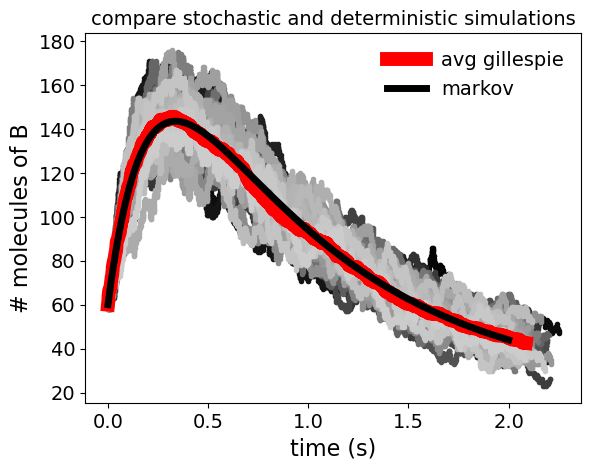

In [26]:
#@title Press the "Play" button on the left to run.

#@markdown This cell runs the Gillespie simulation `num_reps` times and compares
#@markdown the results to a Markov calculation. 

# Run num_reps replicate simulations
num_reps = 50 #@param {type:"integer"}

g = ks.Gillespie(rxn)

print_rxn(rxn)

for i in range(num_reps):
    
    # Create new gillespie model and run for 2,000 steps
    g = ks.Gillespie(rxn)
    for j in range(2000):
        g.take_step()
    
    # Plot replicate result as gray line
    plt.plot(g.conc_history.time,g.conc_history.B,".",color="{}".format(0.8*(i+1)/num_reps))
    
    # Add to average output
    if i == 0:
        avg = np.copy(g.conc_history.B)
    else:
        avg += g.conc_history.B
    
# Finalize average and plot as a red line.
avg = avg/num_reps
plt.plot(g.conc_history.time,avg,"-",lw=10,color="red",label="avg gillespie")
    
# Plot markov model as a black line
plt.plot(m.conc_history.time,m.conc_history.B,"-",lw=5,color="black",label="markov")
plt.xlabel("time (s)")
plt.ylabel("# molecules of B")
plt.title("compare stochastic and deterministic simulations")
plt.legend(frameon=False)
None


### <font color='#9D33FF' size="+2">Argue</font>

<font size="+1">Do the Markov and Gillespie treatments give the same result? (What would "same" mean in this context)?</font>

## The actin polymerization reaction

$$A + A \rightleftarrows A_{2};\ k_{fwd} = 0.001\ s^{-1};\ k_{rev} = 1.000\ s^{-1}$$
$$A + A_{2} \rightleftarrows A_{3};\ k_{fwd} = 0.001\ s^{-1};\ k_{rev} = 1.000\ s^{-1}$$
$$A + A_{3} \rightleftarrows A_{4};\ k_{fwd} = 1.000\ s^{-1};\ k_{rev} = 0.001\ s^{-1}$$
$$...$$
$$A + A_{n} \rightleftarrows A_{n+1};\ k_{fwd} = 1.000\ s^{-1};\ k_{rev} = 0.001\ s^{-1}$$

We are going to run a simulation where we start with `10,000` actin monomers and no other species. The simulation can form actin filaments up to `200` actin subunits long. 



Running simulation for the following reaction scheme:

A1 + A1 -> A2; 0.001
A2 -> A1 + A1; 1.000
A1 + A2 -> A3; 0.001
A3 -> A2 + A1; 1.000
A1 = 1000
A2 = 0
A1 + A3 -> A4; 1.000
A4 -> A1 + A3; 0.001
A3 = 0
A1 + A4 -> A5; 1.000
...
A1 + A147 -> A148; 1.000
A148 -> A1 + A147; 0.001
A147 = 0
A1 + A148 -> A149; 1.000
A149 -> A1 + A148; 0.001
A148 = 0
A1 + A149 -> A150; 1.000
A150 -> A1 + A149; 0.001
A149 = 0
A150 = 0



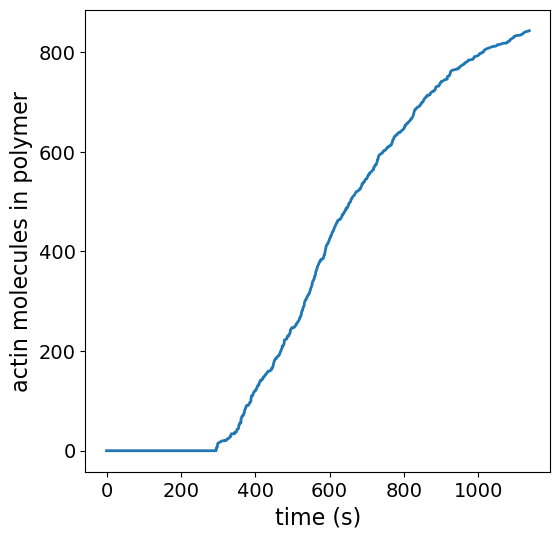

In [27]:
#@title Press the "Play" button on the left to run.

rxn_lines =     ["A1 + A1 -> A2; 0.001"]
rxn_lines.append("A2 -> A1 + A1; 1.000")

rxn_lines.append("A1 + A2 -> A3; 0.001")
rxn_lines.append("A3 -> A2 + A1; 1.000")

rxn_lines.append("A1 = 1000")
rxn_lines.append("A2 = 0")

for i in range(3,150):
    rxn_lines.append("A1 + A{} -> A{}; 1.000".format(i,i+1))
    rxn_lines.append("A{} -> A1 + A{}; 0.001".format(i+1,i))
    rxn_lines.append("A{} = 0".format(i))
rxn_lines.append("A{} = 0".format(i+1))

rxn = "\n".join(rxn_lines)

# Reaction, no effectors
print_rxn(rxn, num_lines=20)
g = ks.Gillespie(rxn)

for i in range(1000):
    g.take_step()
    
_ = plot_actin(g.conc_history)

### <font color='#9D33FF' size="+2">Argue</font>

<font size="+1">What is the origin of the "S-shape" for this curve?</font>

### Effector mechanisms

In [ ]:
#@title Press the "Play" button on the left to run.

# Mechanism #1

mech1 = \
"""
DIP_ARP = 0
A2_ARP = 0
A1_DIP_ARP = 0
A2_DIP_ARP = 0
A3_DIP_ARP = 0

A2 + ARP -> A2_ARP; 1
A2_ARP + DIP -> A2_DIP_ARP; 1
A1 + A2_DIP_ARP -> A3_DIP_ARP; 1
A1 + A3_DIP_ARP -> A4; 1
"""

print_rxn(mech1)

fig = None
ax = None
for c in [0,10,25,100]: 

    initial_conc = f"DIP = {c}\n ARP = 20\n"

    h = ks.Gillespie(rxn + mech1 + initial_conc)
    for i in range(1000):
        h.take_step()

    fig, ax = plot_actin(h.conc_history,fig=fig,ax=ax,label=f"DIP: {c}")

ax.legend()
None

In [ ]:
#@title Press the "Play" button on the left to run.

# Mechanism #2 

mech2 = \
"""
DIP_ARP = 0
A2_ARP = 0
A1_DIP_ARP = 0
A2_DIP_ARP = 0
A3_DIP_ARP = 0

DIP + ARP -> DIP_ARP; 1
A1 + DIP_ARP -> A1_DIP_ARP; 1
A1 + A1_DIP_ARP -> A2_DIP_ARP; 1  
A1 + A2_DIP_ARP -> A3_DIP_ARP; 1
A1 + A3_DIP_ARP -> A4; 1
"""

print_rxn(mech2)

fig = None
ax = None
for c in [0,10,25,100]:

    initial_conc = "DIP = {}\n ARP = 20\n".format(c)
    
    h = ks.Gillespie(rxn + mech2 + initial_conc)
    for i in range(1000):
        h.take_step()

    fig, ax = plot_actin(h.conc_history,fig=fig,ax=ax,label=f"DIP: {c}")

ax.legend()
None